# Tutorial 1: Scattering from a rigid sphere

## The problem

In this tutorial, we will solve the problem of scattering from the unit sphere $\Omega$ with an incident wave defined by

$$
p_{\text{inc}}(\mathbf x) = \mathrm{e}^{\mathrm{i} k x_0}.
$$

where $\mathbf x = (x_0, x_1, x_2)$.

Acoustic waves are governed by the Helmholtz equation:

$$
\Delta p_\text{total} + k^2 p_\text{total} = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega,
$$

where $p_\text{total}$ is the total pressure. We can split $p_\text{total}$ into incident and scattered pressures by writing $p_\text{s}+p_\text{inc}$. The scattered pressure ($p_\text{s}$) satisfies the Sommerfeld radiation condition

$$
\frac{\partial p_\text{s}}{\partial r}-\mathrm{i}kp_\text{s}=o(r^{-1})
$$

when $r:=|\mathbf{x}|\rightarrow\infty$.

For our problem, we impose a Neumann boundary condition:

$$
\frac{\partial p_\text{total}}{\partial\mathbf{n}}=0, \quad \text{ on } \Gamma,
$$

where $\Gamma$ is the surface of the sphere $\Omega$, and $\mathbf{n}$ is the normal to the surface $\Gamma$ (pointing outwards).

## Null field approach

### Representation formula

It can be shown that the total pressure in our problem can be represented as

$$
p_\text{total} = \mathcal{K}p_\text{total} + p_\text{inc}
$$

where $\mathcal{K}$ is the double layer potential operator.

### Boundary integral equation

It can be shown that the total and incident pressures satisfy the following equation on the surface $\Gamma$:

$$
(\mathsf{K}-\tfrac{1}{2}\mathsf{Id})p_\text{total} = -p_\text{inc},
$$

where $\mathsf{K}$ is the double layer boundary operator, and $\mathsf{Id}$ is the identity operator.

### Solving with Bempp

We start by importing Bempp and other libraries we will use.

In [1]:
import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

We set the wavenumber we will use (15), create the discretised sphere, and define a space of piecewise constant functions.

In [2]:
k = 15.

grid = bempp.api.shapes.regular_sphere(3)

space = bempp.api.function_space(grid, "DP", 0)

We define the identity ($\mathsf{Id}$) and double layer ($\mathsf{K}$) boundary operators. Each operator is given three spaces as inputs: the domain, range, and dual spaces (in that order).

In this example, all three spaces are the same. In more complex examples, this will not alwasy be the best choice and spaces must be chosen carefully. The double layer operator also takes the wavenumber as an input.

In [3]:
identity = sparse.identity(space, space, space)
double_layer = helmholtz.double_layer(space, space, space, k)

We define the incident wave, $p_{\text{inc}}(\mathbf x) = \mathrm{e}^{\mathrm{i} k x_0}$, and create a Bempp `GridFunction` to represent its value on the boundary in the discrete space.

We wrap the function defining $p_\text{inc}$ as a `complex_callable`. This is so that Numba knows how to use just-in-time compilation correctly to speed up the creation of the `GridFunction`.

In [4]:
@bempp.api.complex_callable
def p_inc_callable(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])


p_inc = bempp.api.GridFunction(space, fun=p_inc_callable)

We now use GMRES linear solver to solve

$$
(\mathsf{K}-\tfrac{1}{2}\mathsf{Id})p_\text{total} = -p_\text{inc}
$$

We pass three arguments to GMRES: the left hand side operator $\mathsf{K}-\tfrac{1}{2}\mathsf{Id}$; the right hand side `GridFunction` $-p_\text{inc}$; and a tolerance that determines the accuracy of the solver.

Internally, Bempp will create the matrix discretisations of the boundary operators during this step, and use Scipy's GMRES solver.

In [5]:
p_total, info = gmres(double_layer - 0.5 * identity, -p_inc, tol=1E-5)

We now plot a some 2D slices through the solution. First, we use Numpy to create a grid of points to evaluate the solution at.

In [6]:
Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

First, we plot the incident pressure $p_\text{inc}$.

The magic command `%mathplotlib inline` allows matplotlib to display plots inside Jupyter notebooks. This command should be removed if running this outside a notebook.

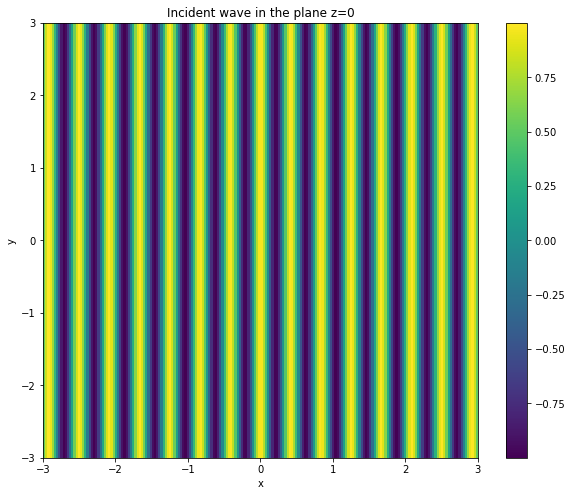

In [7]:
%matplotlib inline

p_inc_evaluated = np.real(np.exp(1j * k * points[0, :]))
p_inc_evaluated = p_inc_evaluated.reshape((Nx, Ny))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(p_inc_evaluated.T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Incident wave in the plane z=0")
plt.show()

Next, we plot the scattered pressure, $p_\text{s}$. This is computed using the equation

$$
p_\text{s} = \mathcal{K}p_\text{total}.
$$


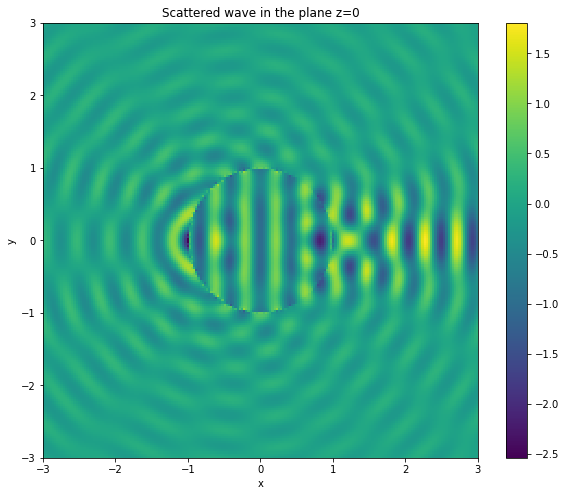

In [8]:
%matplotlib inline

double_pot = helmholtz_potential.double_layer(space, points, k)
p_s = np.real(double_pot.evaluate(p_total))

p_s = p_s.reshape((Nx, Ny))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(p_s.T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Scattered wave in the plane z=0")
plt.show()

Finally, we plot $p_\text{total}$ (which is equal to $p_\text{inc} + p_\text{s}$).

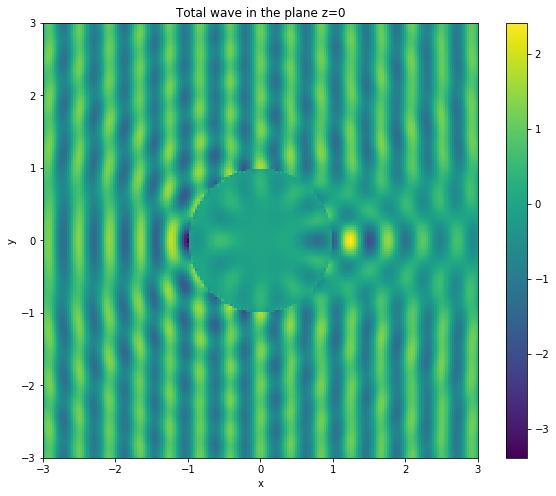

In [9]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real((p_inc_evaluated + p_s).T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")
plt.show()

Using some (slightly ugly) functionality of Numpy, we can hide the solution inside the sphere.

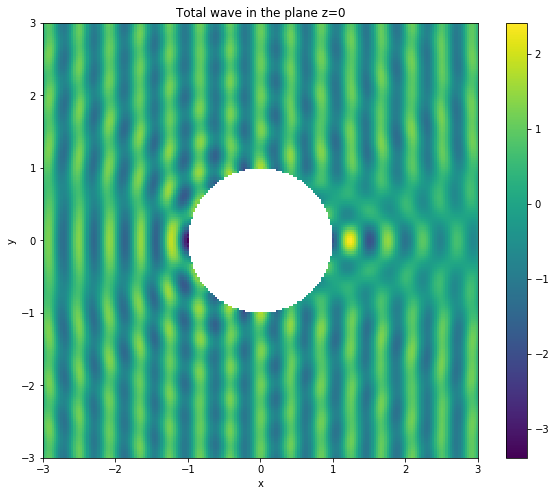

In [10]:
%matplotlib inline

x, y, z = points
idx = np.sqrt(x**2 + y**2) > 1.0

single_pot = helmholtz_potential.single_layer(space, points[:, idx], k)
double_pot = helmholtz_potential.double_layer(space, points[:, idx], k)

p_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
p_evaluated[:] = np.nan
p_evaluated[idx] = np.real(np.exp(1j * k * points[0, idx])
                           + double_pot.evaluate(p_total)).flat
p_evaluated = p_evaluated.reshape((Nx, Ny))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(p_evaluated.T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")
plt.show()

## An alternative approach

### Representation formula

It can be shown that the (unknown) scattered field in our problem can be represented as

$$
p_\text{s} = \int_\Gamma \frac{\partial G(\mathbf x, \mathbf y)}{\partial \mathbf{n}(\mathbf y)}u(\mathbf y)\,\mathrm{d}\mathbf{y} -\int_\Gamma G(\mathbf x, \mathbf y)\lambda(\mathbf y)\,\mathrm{d}\mathbf{y},
$$

where $u$ is the value (or trace) of $p_s$ on $\Gamma$; $\lambda$ is the normal derivative of $p_\text{s}$ on $\Gamma$; and $G(\mathbf x, \mathbf y)$ is the acoustic Green's function given by

$$
G(\mathbf x, \mathbf y):=\frac{\mathrm{e}^{\mathrm{i} k |\mathbf{x}-\mathbf{y}|}}{4 \pi |\mathbf{x}-\mathbf{y}|}.
$$

As we are solving a Neumann problem, $\lambda$ is given by the boundary conditions. In order for the normal derivative of the total field to be 0 on $\Gamma$, we see that

$$\lambda = \frac{\partial p_\text{s}}{\partial\mathbf{n}} = -\frac{\partial p_\text{inc}}{\partial\mathbf{n}} = -\mathrm{i}kn_0\mathrm{e}^{\mathrm{i}kx_0},$$

where $n_0$ is the component of $\mathbf{n}$ in the direction of $x_0$.

Using the single layer ($\mathcal{V}$) and double layer ($\mathcal{K}$) potential operators, the first equation can be rewritten as

$$
p_\text{s} = \mathcal{K}u -\mathcal{V}\lambda.
$$

### Boundary integral equation

Taking the trace of the representation formula, we can derive a boundary integral equation. Using the single layer ($\mathsf{V}$), double layer ($\mathsf{K}$) and identity ($\mathsf{Id}$) boundary operators, this can be written as

$$
(\mathsf{K} - \tfrac{1}{2}\mathsf{Id})u  = \mathsf{V}\lambda.
$$

We will solve a discretisation of the equation to find (an approximation of) $p_s$ on the surface $\Gamma$. This can then be used with the representation formula to evaluate $p_\text{s}$ at various points outside the sphere.

### Solving with Bempp

The following code has been adapted from the null field example above. It solves the boundary integral equation

$$
(\mathsf{K} - \tfrac{1}{2}\mathsf{Id})u = \mathsf{V}\lambda,
$$

then uses the solution to compute the values at various points using the representation formula

$$
p_\text{s} = \mathcal{K}u -\mathcal{V}\lambda.
$$

/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


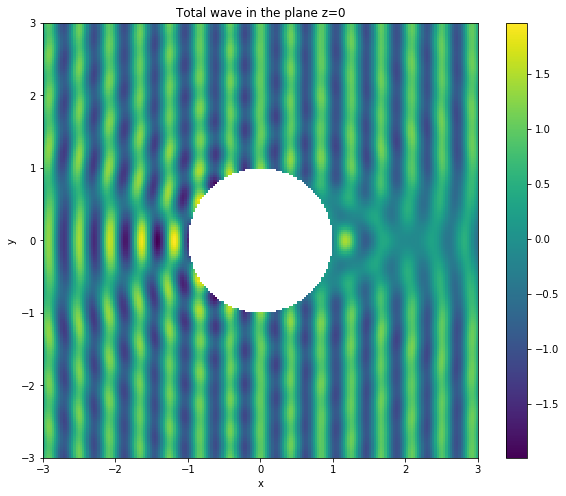

In [11]:
%matplotlib inline
import bempp.api
from bempp.api.operators.boundary import helmholtz, sparse
from bempp.api.operators.potential import helmholtz as helmholtz_potential
from bempp.api.linalg import gmres
import numpy as np
from matplotlib import pyplot as plt

k = 15.

grid = bempp.api.shapes.regular_sphere(3)

space = bempp.api.function_space(grid, "DP", 0)

identity = sparse.identity(space, space, space)
double_layer = helmholtz.double_layer(space, space, space, k)
single_layer = helmholtz.single_layer(space, space, space, k)


@bempp.api.complex_callable
def lambda_callable(x, n, domain_index, result):
    result[0] = -1j * k * np.exp(1j * k * x[0]) * n[0]


lambda_fun = bempp.api.GridFunction(space, fun=lambda_callable)

u, info = gmres(double_layer - 0.5 * identity, single_layer * lambda_fun, tol=1E-5)

Nx = 200
Ny = 200
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

x, y, z = points
idx = np.sqrt(x**2 + y**2) > 1.0

single_pot = helmholtz_potential.single_layer(space, points[:, idx], k)
double_pot = helmholtz_potential.double_layer(space, points[:, idx], k)

u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
u_evaluated[:] = np.nan
u_evaluated[idx] = np.real(np.exp(1j * k * points[0, idx])
                           + double_pot.evaluate(u)
                           - single_pot.evaluate(lambda_fun)).flat
u_evaluated = u_evaluated.reshape((Nx, Ny))

fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(u_evaluated.T), extent=[-3, 3, -3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("Total wave in the plane z=0")
plt.show()